In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(np.array(train_pixels).shape)

(35887, 2304)


In [ ]:
print("Train Directory Structure:")
for emotion in emotions.values():
    print(f"{emotion}: {os.listdir(os.path.join(train_dir, emotion))}")


Train Directory Structure:
Angry: ['6371.jpg', '518.jpg', '8224.jpg', '3179.jpg', '28038.jpg', '4041.jpg', '32660.jpg', '22976.jpg', '8871.jpg', '10183.jpg', '8709.jpg', '905.jpg', '34749.jpg', '28834.jpg', '2218.jpg', '19612.jpg', '12687.jpg', '31523.jpg', '23682.jpg', '11874.jpg', '35244.jpg', '2837.jpg', '35027.jpg', '5130.jpg', '30101.jpg', '17124.jpg', '15649.jpg', '33986.jpg', '23885.jpg', '20233.jpg', '14915.jpg', '17890.jpg', '9023.jpg', '9952.jpg', '16524.jpg', '31372.jpg', '2242.jpg', '9661.jpg', '32699.jpg', '12623.jpg', '8727.jpg', '10219.jpg', '12647.jpg', '7290.jpg', '30901.jpg', '5039.jpg', '21362.jpg', '17561.jpg', '4060.jpg', '3863.jpg', '676.jpg', '15856.jpg', '18994.jpg', '19402.jpg', '11641.jpg', '16232.jpg', '18857.jpg', '4173.jpg', '19555.jpg', '29341.jpg', '7200.jpg', '4114.jpg', '17080.jpg', '9747.jpg', '5902.jpg', '35234.jpg', '642.jpg', '24173.jpg', '15620.jpg', '30159.jpg', '17272.jpg', '22466.jpg', '8054.jpg', '9321.jpg', '13904.jpg', '16178.jpg', '15344.jpg

In [ ]:
import os
import shutil
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers, models

# 使用 FER2013 CSV 檔案
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/人工智慧導論/fer2013.csv')

# 定義情緒對應的資料夾名稱
emotions = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral"
}

# 設置資料夾結構
dataset_path = 'fer2013'
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

# 創建 train 和 test 目錄
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# 設置每個情緒類別的資料夾
for emotion in emotions.values():
    os.makedirs(os.path.join(train_dir, emotion), exist_ok=True)
    os.makedirs(os.path.join(test_dir, emotion), exist_ok=True)

# 隨機打亂資料集
df = df.sample(frac=1).reset_index(drop=True)

# 將標籤轉換為 one-hot 編碼
labels = to_categorical(df[['emotion']], num_classes=7)

# 將圖像像素處理成 NumPy 陣列
train_pixels = df["pixels"].astype(str).str.split(" ").tolist()
train_pixels = np.uint8([list(map(int, pixel)) for pixel in train_pixels])

# 重塑圖像資料為 (樣本數, 48, 48, 1)
pixels = train_pixels.reshape((df.shape[0], 48, 48, 1))

# 使用 stratified sampling 隨機分配資料，確保訓練集與測試集的比例相同
X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.1, shuffle=True, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, stratify=y_train)


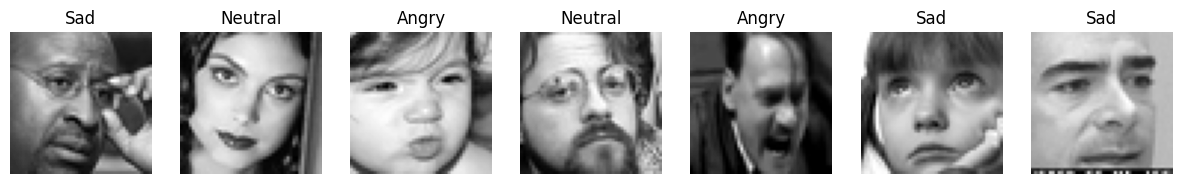

In [ ]:
# 顯示訓練集中的 7 張圖像
plt.figure(figsize=(15, 23))
label_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

for i in range(7):
    img = np.squeeze(X_train[i])  # 刪除不必要的維度
    plt.subplot(1, 7, i + 1)
    plt.imshow(img, cmap='gray')  # 顯示灰階圖像
    index = np.argmax(y_train[i])  # 獲取該圖像的情緒標籤
    plt.title(label_dict[index])
    plt.axis('off')

plt.show()

# 儲存訓練圖像到對應的資料夾
for i in range(len(df)):
    emotion_label = df.iloc[i]['emotion']
    emotion_folder = emotions[emotion_label]
    pixels_array = np.array(train_pixels[i]).reshape(48, 48)  # 重塑為 48x48 圖像
    img_path = os.path.join(train_dir, emotion_folder, f"{i}.jpg")
    cv2.imwrite(img_path, pixels_array)

    # 分配 10% 資料到測試集
    if i % 10 == 0:
        img_path_test = os.path.join(test_dir, emotion_folder, f"{i}.jpg")
        cv2.imwrite(img_path_test, pixels_array)


In [ ]:
# 定義CNN模型
def cnn_model():
    model = tf.keras.models.Sequential()

    # 第一層卷積層
    model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))  # 防止過擬合

    # 第二層卷積層
    model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    # 扁平化並連接到全連接層
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))  # 更高的 Dropout 防止全連接層過擬合

    # 輸出層
    model.add(tf.keras.layers.Dense(7, activation='softmax'))  # FER2013 有 7 種情緒類別

    # 編譯模型
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # 減小學習率
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    model.summary()  # 輸出模型結構
    return model

# 創建模型
model = cnn_model()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,200,391 (4.58 MB)

 Trainable params: 1,199,943 (4.58 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os

# 回調函數
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

# 訓練集和測試集生成
train_dataset_no_repeat = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    color_mode='grayscale',
    image_size=(48, 48),
    batch_size=64
)

train_dataset = train_dataset_no_repeat.repeat()  # 無限循環訓練集

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    color_mode='grayscale',
    image_size=(48, 48),
    batch_size=64
)

# 計算類別權重
train_labels = np.concatenate([y for x, y in train_dataset_no_repeat])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(train_labels, axis=1)),
    y=np.argmax(train_labels, axis=1)
)
class_weights = dict(enumerate(class_weights))

# 計算 steps_per_epoch 和 validation_steps
train_images_count = sum([len(files) for _, _, files in os.walk(train_dir)])
test_images_count = sum([len(files) for _, _, files in os.walk(test_dir)])

# 直接計算 steps_per_epoch 和 validation_steps
batch_size = 64
steps_per_epoch = train_images_count // batch_size
validation_steps = test_images_count // batch_size

# 訓練模型
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    epochs=20,
    callbacks=[early_stopping, lr_scheduler],
    class_weight=class_weights
)


Found 90013 files belonging to 7 classes.
Found 8954 files belonging to 7 classes.
Epoch 1/20
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 527s 375ms/step - accuracy: 0.4043 - loss: 1.7528 - val_accuracy: 0.4904 - val_loss: 1.5952 - learning_rate: 1.0000e-04
Epoch 2/20
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 513s 365ms/step - accuracy: 0.4467 - loss: 1.6059 - val_accuracy: 0.4138 - val_loss: 1.5937 - learning_rate: 1.0000e-04
Epoch 3/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1406/1406 ━━━━━━━━━━━━━━━━━━━━ 519s 370ms/step - accuracy: 0.4749 - loss: 1.5074 - val_accuracy: 0.5450 - val_loss: 1.4397 - learning_rate: 1.0000e-04
Epoch 4/20
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 551s 392ms/step - accuracy: 0.5007 - loss: 1.4147 - val_accuracy: 0.4828 - val_loss: 1.4369 - learning_rate: 1.0000e-04
Epoch 5/20
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 522s 371ms/step - accuracy: 0.5171 - loss: 1.3506 - val_accuracy: 0.5900 - val_loss: 1.3294 - learning_rate: 1.0000e-04
Epoch 6/20
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 551s 391ms/step - accuracy: 0.5381 - loss: 1.2877 - val_accuracy: 0.6897 - val_loss: 1.0945 - learning_rate: 1.0000e-04
Epoch 7/20
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 523s 372ms/step - accuracy: 0.5491 - loss: 1.2562 - val_accuracy: 0.6450 - val_loss: 1.1857 - learning_rate: 1.0000e-04
Epoch 8/20
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 550s 391ms/step - accuracy: 0.5644 - loss: 1.2042 - val_accuracy: 0.7241 - val_loss: 0.9940 - learning_rate: 1.0000e-04
Epoch 9/20
1406/1406 ━━━━━━━━━━━━━━━━━━

In [ ]:
from keras.models import model_from_json
model.save('Face_cnn_model.h5')
print("Face_cnn_model.h5模型儲存完畢!")

Face_cnn_model.h5模型儲存完畢!


In [ ]:
#從HDF5檔案中載入
from keras.models import load_model
print('載入模型Face_cnn_model.h5')
model = load_model('Face_cnn_model.h5')

載入模型Face_cnn_model.h5


In [ ]:
from google.colab import files
files.download('Face_cnn_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 在測試集上評估模型
test_loss, test_accuracy = model.evaluate(
    test_dataset,
    steps=validation_steps,  # 計算每個 epoch 的步數
    verbose=1  # 顯示進度條
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")



139/139 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step - accuracy: 0.8654 - loss: 0.6763
Test Loss: 0.6842
Test Accuracy: 0.8616


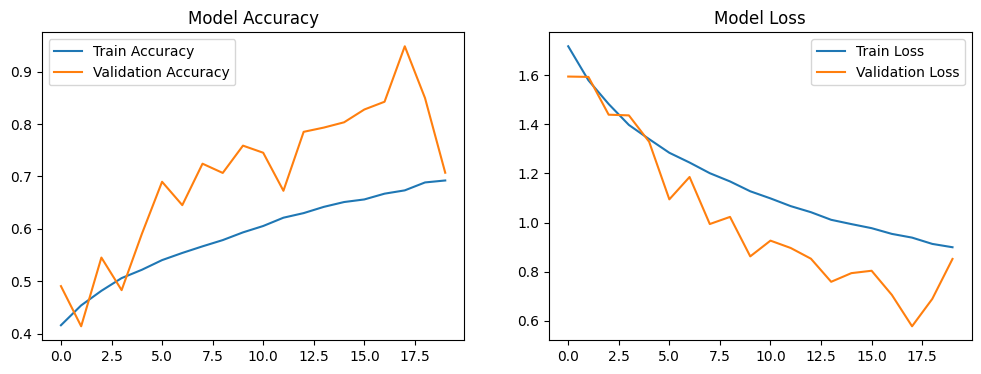

In [ ]:
import matplotlib.pyplot as plt

# Step 7: 繪製訓練過程的圖表
plt.figure(figsize=(12, 4))

# 訓練準確度與驗證準確度
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

# 訓練損失與驗證損失
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')

# 顯示圖表
plt.show()


140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step


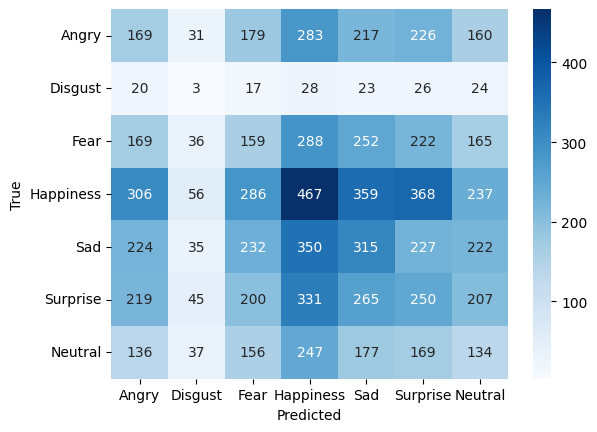

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = np.argmax(np.concatenate([y for x, y in test_dataset]), axis=1)
y_pred = np.argmax(model.predict(test_dataset), axis=1)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_dict.values(), yticklabels=label_dict.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step


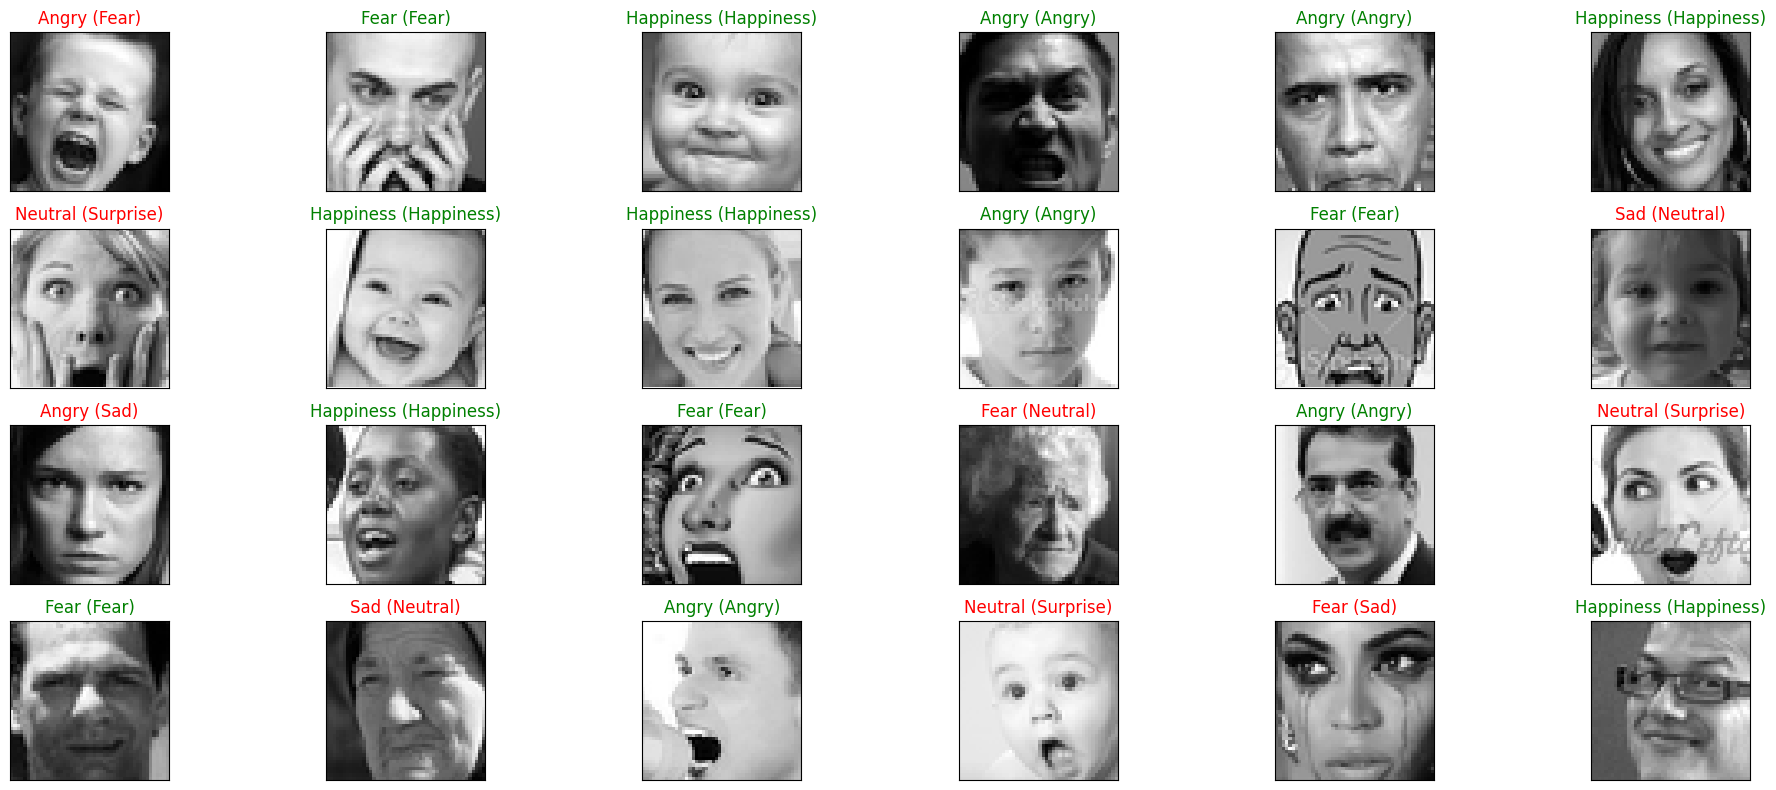

In [ ]:
# 預測測試集的情緒
y_pred = model.predict(X_test)

# 定義情緒標籤字典
label_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# 設置圖表大小
figure = plt.figure(figsize=(20, 8))

# 隨機選擇 24 張測試圖片
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]), cmap='gray')  # 顯示灰階圖像
    predict_index = label_dict[np.argmax(y_pred[index])]  # 預測情緒標籤
    true_index = label_dict[np.argmax(y_test[index])]  # 真實情緒標籤

    # 設定標題，根據預測是否正確來顯示顏色
    ax.set_title("{} ({})".format(predict_index, true_index),
                 color=("green" if predict_index == true_index else "red"))

plt.tight_layout()
plt.show()


In [ ]:
# Step 8: 預測和混淆矩陣
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 預測測試集
y_pred = model.predict(test_dataset, steps=validation_steps)  # 使用 test_dataset 進行預測
y_pred_classes = np.argmax(y_pred, axis=1)  # 轉換預測結果為類別
y_true = np.concatenate([y for _, y in test_dataset])  # 真實標籤

# 顯示分類報告
print("分類報告:")
print(classification_report(y_true, y_pred_classes, target_names=test_dataset.class_names))

# 計算混淆矩陣
conf_mat = confusion_matrix(y_true, y_pred_classes)

# 繪製混淆矩陣
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.class_names, yticklabels=test_dataset.class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('混淆矩陣')
plt.show()


139/139 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step
分類報告:


ValueError: Found input variables with inconsistent numbers of samples: [8954, 8896]

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import tensorflow as tf

# 載入訓練好的模型
model = tf.keras.models.load_model('/content/Face_cnn_model.h5')  # 請替換為實際的模型路徑

# 設置情緒標籤
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# 開啟攝像頭
cap = cv2.VideoCapture(0)

while True:
    # 捕獲一幀影像
    ret, frame = cap.read()
    if not ret:
        break

    # 將影像轉為灰階
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 使用 OpenCV 的人臉偵測
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    # 處理每一個偵測到的人臉
    for (x, y, w, h) in faces:
        # 擷取人臉區域
        face = gray[y:y+h, x:x+w]
        face_resized = cv2.resize(face, (48, 48))  # 調整大小為模型輸入大小 (48x48)

        # 擴展維度以符合模型輸入
        face_resized = face_resized.reshape(1, 48, 48, 1)
        face_resized = face_resized.astype('float32') / 255.0  # 標準化處理

        # 使用模型進行預測
        predictions = model.predict(face_resized)
        max_index = np.argmax(predictions[0])  # 找到最大預測值對應的情緒
        predicted_emotion = emotions[max_index]

        # 在影像上繪製人臉區域和預測的情緒
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)  # 繪製綠色矩形框
        cv2.putText(frame, predicted_emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # 顯示即時影像
    cv2_imshow(frame)

    # 按 'q' 鍵退出
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# 釋放資源
cap.release()
cv2.destroyAllWindows()


In [ ]:
pip install opencv-python
